# MMC ABL postprocessing

In [1]:
# Load the modules

# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)
import MMCutil as writeMMC
import postproamrwindsample_xarray as ppsamplexr

# Load the libraries
import numpy as np
import pandas as pd
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import CubicSpline

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
rundir = '/nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMCdemo_neutral1_10x10_20'
postprodir= rundir+'/post_processing'
iters     = [2160]         # timesteps to extract
varnames  = ['velocityx', 'velocityy']  # variables to extract
hhdb      = ppsamplexr.getPlaneXR(postprodir+'/hubheight_00000.nc', iters, varnames, verbose=1, gettimes=True)

extracting iter 2160


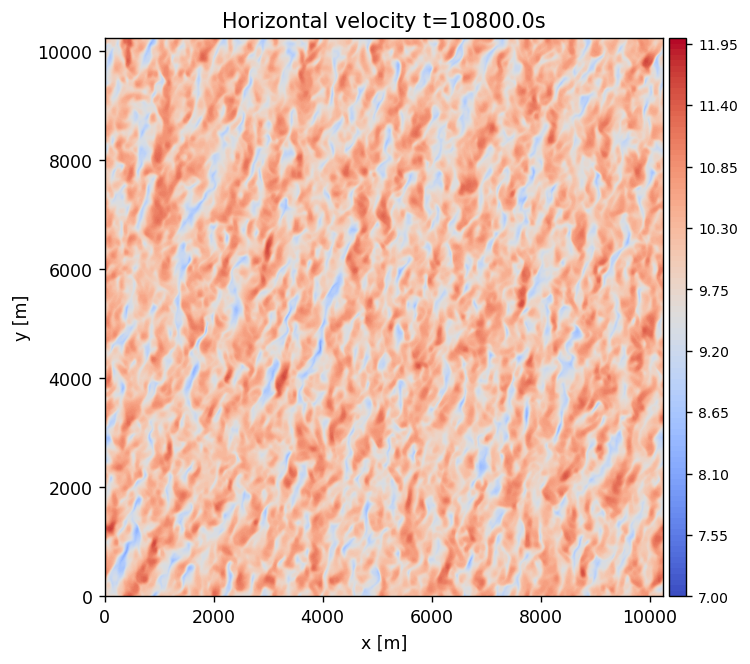

In [3]:
#plt.figure(figsize=(5,4), dpi=125)
fig, ax = plt.subplots(1,1,figsize=(6,6), dpi=125)
clevels=np.linspace(7, 12,101)
iplane=0
i=2160
Uh=np.sqrt(hhdb['velocityx'][i][iplane,:,:]**2+hhdb['velocityy'][i][iplane,:,:]**2)
c=ax.contourf(hhdb['x'][iplane,:,:], hhdb['y'][iplane,:,:], Uh, levels=clevels, cmap='coolwarm')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar=fig.colorbar(c, ax=ax, cax=cax)
cbar.ax.tick_params(labelsize=8)

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Horizontal velocity t=%0.1fs'%hhdb['times'][0])
ax.set_aspect('equal')


In [4]:
swdb      = ppsamplexr.getPlaneXR(postprodir+'/sw_00000.nc', iters, varnames, verbose=1, gettimes=True)

extracting iter 2160


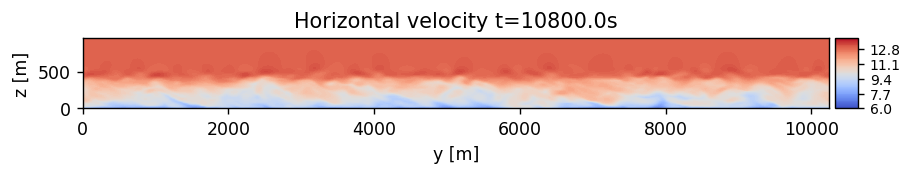

In [5]:
fig, ax = plt.subplots(1,1,figsize=(8,4), dpi=125)
clevels=np.linspace(6, 14,81)
iplane=0
i=swdb['timesteps'][0]
Uh=np.sqrt(swdb['velocityx'][i][iplane,:,:]**2+swdb['velocityy'][i][iplane,:,:]**2)
c = ax.contourf(swdb['y'][iplane,:,:], swdb['z'][iplane,:,:], Uh, levels=clevels, cmap='coolwarm')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
cbar=fig.colorbar(c, ax=ax, cax=cax)
cbar.ax.tick_params(labelsize=8)
cbar.ax.locator_params(nbins=5)

ax.set_xlabel('y [m]')
ax.set_ylabel('z [m]')
ax.set_title('Horizontal velocity t=%0.1fs'%swdb['times'][0])
ax.set_aspect('equal')

In [6]:
# Start the amrwind_frontend app 
case = amrwind.MyApp.init_nogui()

In [7]:
case.ABLpostpro_loadnetcdffile(rundir+'/post_processing/abl_statistics00000.nc')

Loading /nscratch/lcheung/FLOWMAS/microscale_surrogate_wakes/MMCdemo_neutral1_10x10_20/post_processing/abl_statistics00000.nc
Time range: 0.500000 to 14400.000000
Done.


In [8]:
# Load the data from the csv file
csvfile = '../NOW23_analysis/data/neutral_profile.csv'
profile = pd.read_csv(csvfile)
zMMC     = np.array(profile['height']) 
avgtimes = [[3600-600, 3600],
            [7200-600, 7200],
            #[10000-600, 10000],
            [10800-600, 10800],
            [14400-600, 14400],
           ]

Loading u
Loading v
Loading u
Loading v
Loading u
Loading v
Loading u
Loading v


Text(0.5, 0.98, 'Horizontal velocity [10-min avg]')

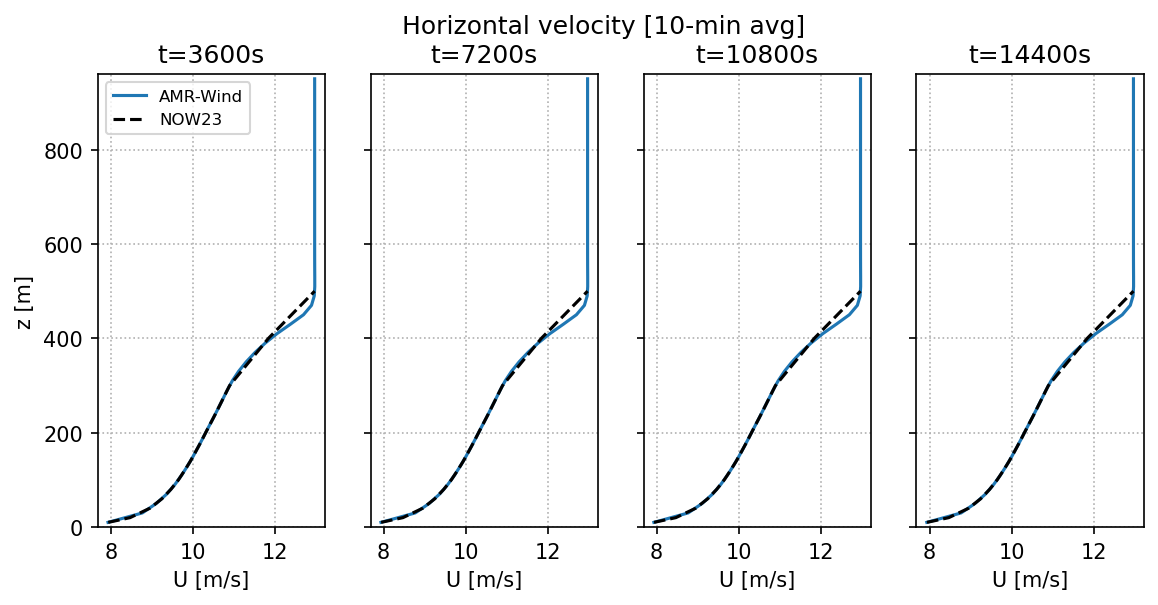

In [9]:
# Plot velocity
fig, axs = plt.subplots(1,len(avgtimes),figsize=(2.25*len(avgtimes),4), facecolor='w', dpi=150, sharey=True)
for it, avgt in enumerate(avgtimes):
    ax=axs[it]
    dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['Uhoriz'], avgt=avgt, doplot=False)
    ax.plot(dat['Uhoriz']['data'], dat['Uhoriz']['z'], label='AMR-Wind')
    ax.plot(np.sqrt(np.array(profile['u'])**2 + np.array(profile['v'])**2), zMMC, 'k--', label='NOW23')
    ax.set_xlabel('U [m/s]')
    ax.set_title('t=%.0fs'%avgt[1])
    ax.grid(linestyle=':')
    
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 960])
axs[0].legend(prop={'size':8})

fig.suptitle('Horizontal velocity [10-min avg]')

Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r
Loading u'u'_r
Loading v'v'_r
Loading w'w'_r


Text(0.5, 0.98, 'TKE profiles [10-min avg]')

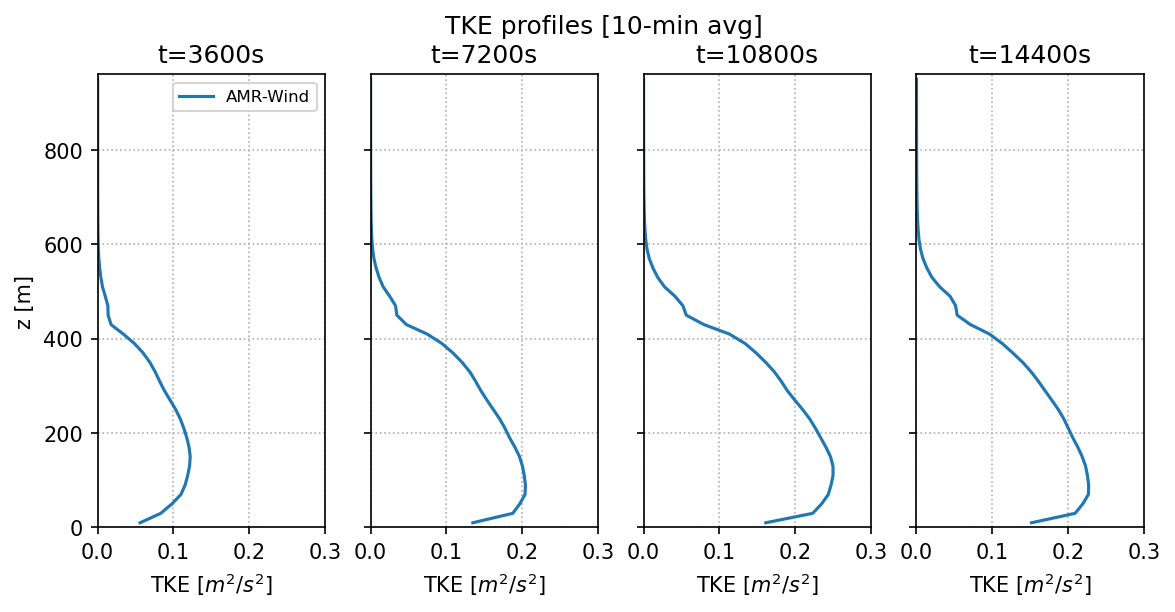

In [10]:
# Plot TKE
fig, axs = plt.subplots(1,len(avgtimes),figsize=(2.25*len(avgtimes),4), facecolor='w', dpi=150, sharey=True)
for it, avgt in enumerate(avgtimes):
    ax=axs[it]
    dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['TKE'], avgt=avgt, doplot=False)
    ax.plot(dat['TKE']['data'], dat['TKE']['z'], label='AMR-Wind')
    #ax.plot(np.sqrt(np.array(profile['u'])**2 + np.array(profile['v'])**2), zMMC, 'k--')
    ax.set_xlabel('TKE [$m^2/s^2$]')
    ax.set_title('t=%.0fs'%avgt[1])
    ax.set_xlim([0, 0.3])
    ax.grid(linestyle=':')
    

axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 960])
axs[0].legend(prop={'size':8})

fig.suptitle('TKE profiles [10-min avg]')

Loading theta
Loading theta
Loading theta
Loading theta


Text(0.5, 0.98, 'Temperature profiles [10-min avg]')

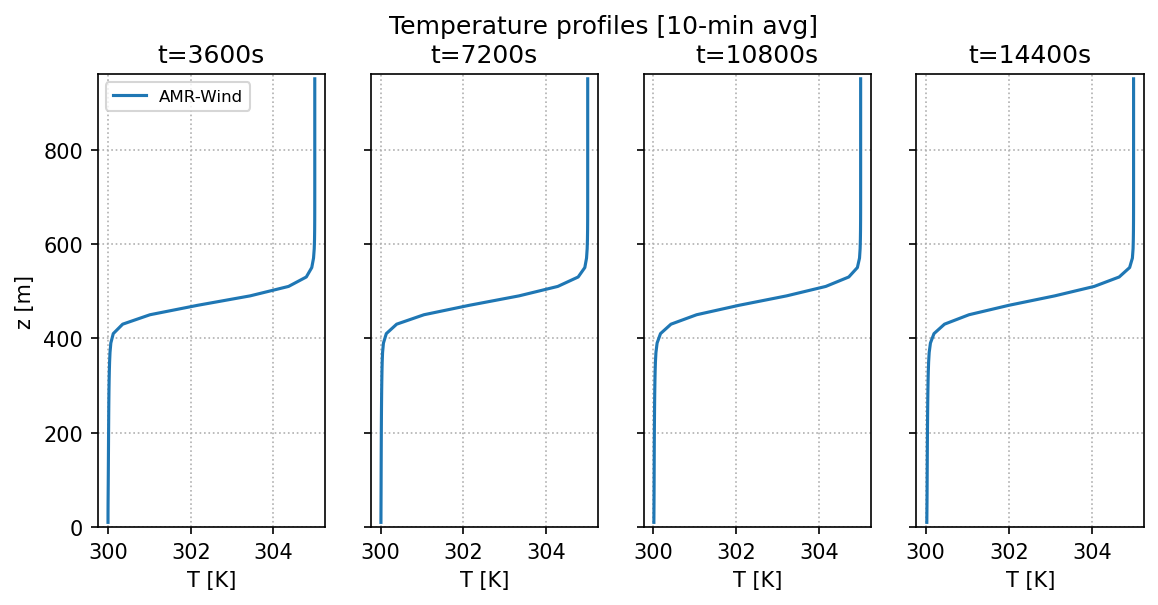

In [11]:
# Plot Temperature
fig, axs = plt.subplots(1,len(avgtimes),figsize=(2.25*len(avgtimes),4), facecolor='w', dpi=150, sharey=True)
for it, avgt in enumerate(avgtimes):
    ax=axs[it]
    dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['Temperature'], avgt=avgt, doplot=False)
    ax.plot(dat['T']['data'], dat['T']['z'], label='AMR-Wind')
    #ax.plot(np.sqrt(np.array(profile['u'])**2 + np.array(profile['v'])**2), zMMC, 'k--')
    ax.set_xlabel('T [K]')
    ax.set_title('t=%.0fs'%avgt[1])
    ax.grid(linestyle=':')
    #ax.set_xlim([0, 0.3])
    
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 960])
axs[0].legend(prop={'size':8})

fig.suptitle('Temperature profiles [10-min avg]')

Loading u
Loading v
15.964445372140233
Loading u
Loading v
15.964085896018219
Loading u
Loading v
15.964635842447422
Loading u
Loading v
15.964202370284227


Text(0.5, 0.98, 'Wind Direction [10-min avg]')

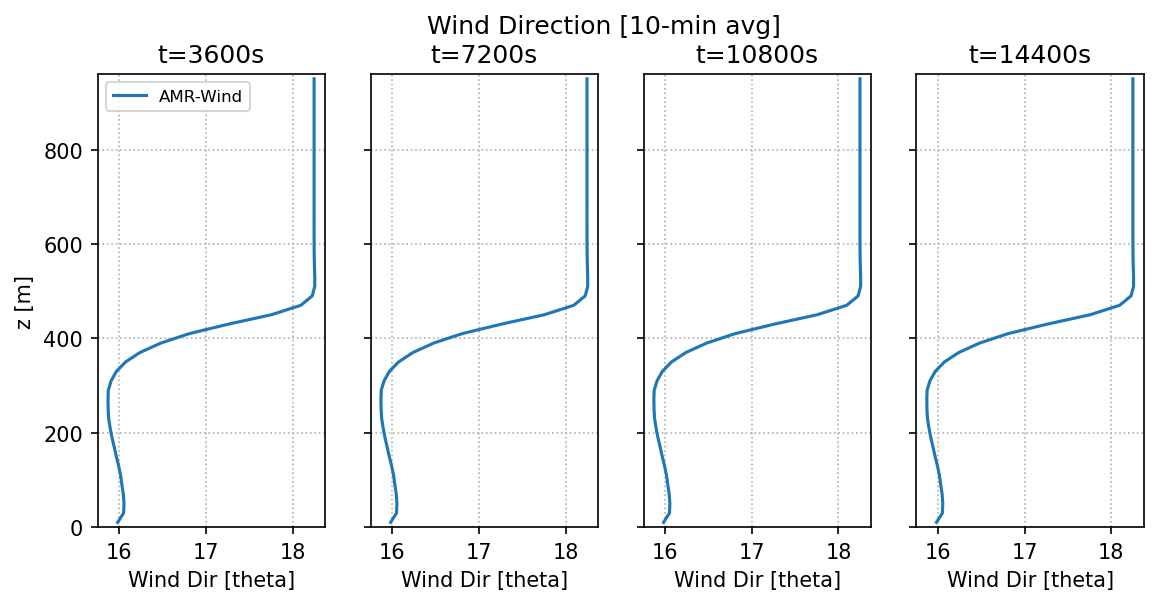

In [20]:
# Plot Temperature
fig, axs = plt.subplots(1,len(avgtimes),figsize=(2.25*len(avgtimes),4), facecolor='w', dpi=150, sharey=True)
for it, avgt in enumerate(avgtimes):
    ax=axs[it]
    dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['WindDir'], avgt=avgt, doplot=False)
    ax.plot(dat['WindDir']['data']-360, dat['WindDir']['z'], label='AMR-Wind')
    print(np.interp(150, dat['WindDir']['z'], dat['WindDir']['data']-360))
    #ax.plot(np.sqrt(np.array(profile['u'])**2 + np.array(profile['v'])**2), zMMC, 'k--')
    ax.set_xlabel('Wind Dir [theta]')
    ax.set_title('t=%.0fs'%avgt[1])
    ax.grid(linestyle=':')
    #ax.set_xlim([0, 0.3])
    
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 960])
axs[0].legend(prop={'size':8})

fig.suptitle('Wind Direction [10-min avg]')

In [12]:
#dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['MMC-forcing'], avgt=avgt, doplot=False)

Loading abl_meso_forcing_mom_x
Loading abl_meso_forcing_mom_y


Loading abl_meso_forcing_mom_x
Loading abl_meso_forcing_mom_y
Loading abl_meso_forcing_mom_x
Loading abl_meso_forcing_mom_y
Loading abl_meso_forcing_mom_x
Loading abl_meso_forcing_mom_y
Loading abl_meso_forcing_mom_x
Loading abl_meso_forcing_mom_y


Text(0.5, 0.98, 'MMC body forcing [10-min avg]')

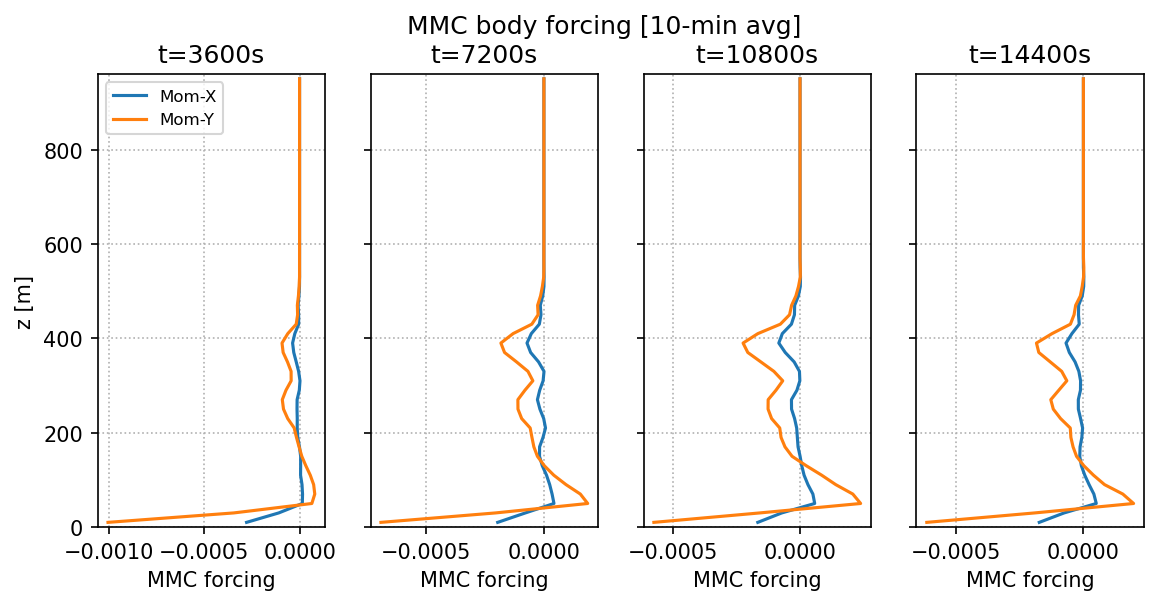

In [14]:
# Plot MMC body forcing
fig, axs = plt.subplots(1,len(avgtimes),figsize=(2.25*len(avgtimes),4), facecolor='w', dpi=150, sharey=True)
for it, avgt in enumerate(avgtimes):
    ax=axs[it]
    dat=case.ABLpostpro_plotprofiles(ax=ax, plotvars=['MMC-forcing'], avgt=avgt, doplot=False)
    ax.plot(dat['abl_meso_forcing_mom_x']['data'], dat['abl_meso_forcing_mom_x']['z'], label='Mom-X')
    ax.plot(dat['abl_meso_forcing_mom_y']['data'], dat['abl_meso_forcing_mom_y']['z'], label='Mom-Y')
    
    ax.set_xlabel('MMC forcing')
    ax.set_title('t=%.0fs'%avgt[1])
    ax.grid(linestyle=':')
    
axs[0].set_ylabel('z [m]')
axs[0].set_ylim([0, 960])
axs[0].legend(prop={'size':8})

fig.suptitle('MMC body forcing [10-min avg]')